In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**bifurcation map**

In [2]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746522 sha256=752e342e669178f9e179a86b53269bdfe2c5eb4fd4e02314607835b8fceb1d23
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [3]:
%%writefile bifurcation_diagram_MPI.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

x0 = 0.1
r_min, r_max = 1, 5.0
num_steps = 10000
n, k = 1000, 500

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

start_time = MPI.Wtime()

local_n = num_steps // size
r_min_local = r_min + rank * local_n * (r_max-r_min) / num_steps
r_max_local = r_min_local + local_n * (r_max-r_min) / num_steps
local_r_values = np.linspace(r_min_local, r_max_local, local_n)


local_bifurcations = []

def logistic_map(x, r):
    return r * x * (1. - x)

for r in local_r_values:
    x = x0
    for i in range(n + k):
        if i >= k:
            local_bifurcations.append([r, x])
        x = logistic_map(x, r)


all_bifurcation = np.empty(local_n * size, dtype=np.float32)
all_bifurcation = comm.gather(local_bifurcations, root=0)

end_time = MPI.Wtime()
mpi_time = end_time - start_time

MPI.Finalize()

if rank == 0:

    data = np.concatenate(all_bifurcation)
    print(mpi_time)

    plt.scatter(data[:,0], data[:,1], s=1)
    plt.xlabel('r')
    plt.ylabel('x')
    plt.savefig('Bif_mpi.png')

Writing bifurcation_diagram_MPI.py


In [5]:
!mpirun -n 4 --allow-run-as-root --oversubscribe python bifurcation_diagram_MPI.py

75.604295081


**Serial**

In [6]:
from scipy.integrate import quad

In [7]:
x0 = 0.1
r_min, r_max = 1, 5.0
num_steps = 10000
n, k = 1000, 500

In [8]:
def logistic_map(x, r):
    return r * x * (1. - x)

In [9]:
def bifurcation_diagram(x0, r_min, r_max, num_steps, n, k):
    r_list = np.linspace(r_min, r_max, num_steps)
    bifurcations = []

    for r in r_list:
        x = x0
        for i in range(n + k):
            if i >= k:
                bifurcations.append([r, x])
            x = logistic_map(x, r)


    bifurcations = np.array(bifurcations)
    return bifurcations

<ipython-input-8-edb46471b6cc>:2: RuntimeWarning: overflow encountered in double_scalars
  return r * x * (1. - x)


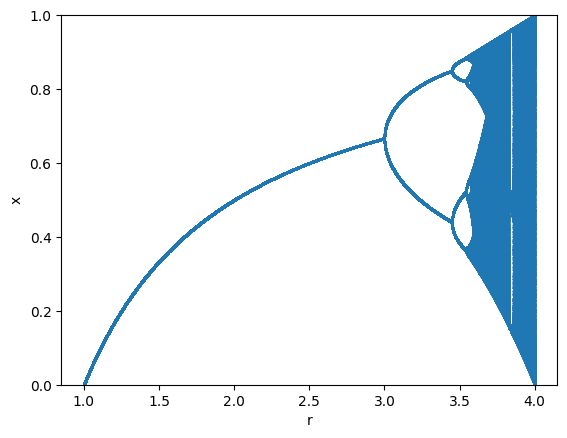

In [10]:
bifurcations = bifurcation_diagram(x0, r_min, r_max, num_steps, n, k)
plot(bifurcations[:,0], bifurcations[:,1], 'o', markersize=0.2)
xlabel('r')
ylim(0, 1)
ylabel('x')
show()

In [11]:
serial_time = %timeit -o bifurcation_diagram(x0, r_min, r_max, num_steps, n, k)
serial_time.best

<ipython-input-8-edb46471b6cc>:2: RuntimeWarning: overflow encountered in double_scalars
  return r * x * (1. - x)


12.4 s ± 555 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


11.400982109999973

In [ ]:
def mpi(N):
  mpi_time = !mpirun -n {N} --allow-run-as-root --oversubscribe python bifurcation_diagram_MPI.py
  return mpi_time

num_processes = [1, 2, 4, 8, 16]
parallel_time, number_processes = [], []
serial_time = [serial_time.best]*len(num_processes)

for N in num_processes:
    number_processes.append(N)
    parallel_time.append(float32(mpi(N)))

speedup = [parallel / serial for parallel, serial in zip(parallel_time, serial_time)]

In [ ]:
plot(num_processes, speedup, marker='o')
xlabel('Number of Processes')
ylabel('Speedup')
title('Speedup vs. Number of Processes')
show()

**spectrogram**

In [ ]:
# generate the signal
nofts=1000

t=np.linspace(-20*2*pi, 20*2*pi, 2**14+7)

y=np.sin(t)*exp(-t**2/2/20**2)
y=y+np.sin(3*t)*exp(-(t-5*2*pi)**2/2/20**2)
y=y+np.sin(5.5*t)*exp(-(t-10*2*pi)**2/2/5**2)
y=y+np.sin(4*t)*exp(-(t-7*2*pi)**2/(2*5**2))

plt.plot(t/2/pi,y)

xlabel('t, cycles')
ylabel('signal, arb.units')

In [ ]:
def get_spectrogram(time=t, signal=y, nwindowsteps=1000):

    data = np.zeros((time.shape[0], nwindowsteps))
    width = 1
    positions_list = np.linspace(-20, 20, nwindowsteps)

    for pos_id, position in enumerate(positions_list):
        window_width = width*2* pi
        window_position = position*2*pi
        window_function = exp(-(time - window_position)**2 / (2 * window_width**2))
        y_window = signal * window_function
        data[:, pos_id] = abs(np.fft.fft(y_window))

    return data

In [ ]:
get_spectrogram()

In [ ]:
serial_time = %timeit -o get_spectrogram()
serial_time.best

In [ ]:
%%writefile spectrogram_MPI.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

    ### generate the signal

nwindowsteps=1000


t=np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14+7)

y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*np.pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*np.pi)**2/2/5**2)
y=y+np.sin(4*t)*np.exp(-(t-7*2*np.pi)**2/(2*5**2))

time, signal =t, y

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

start_time = MPI.Wtime()


data = np.zeros((time.shape[0], nwindowsteps))
width = 1
positions_list = np.linspace(-20, 20, nwindowsteps)

# Divide the range of positions into equal-sized chunks
local_n = nwindowsteps // size
start_index = rank * local_n
end_index = (rank + 1) * local_n


for pos_id, position in enumerate(positions_list[start_index:end_index]):
    window_width = width * 2 * np.pi
    window_position = position * 2 * np.pi
    window_function = np.exp(-(time - window_position)**2 / (2 * window_width**2))
    y_window = signal * window_function
    data[:, start_index + pos_id] = np.abs(np.fft.fft(y_window))

result = comm.gather(data, root=0)

end_time = MPI.Wtime()
mpi_time = end_time - start_time

MPI.Finalize()

if rank == 0:
        result = np.concatenate(result, axis=1)
        print(mpi_time)

In [ ]:
!mpirun -n 8 --allow-run-as-root --oversubscribe python spectrogram_MPI.py

In [ ]:
def mpi(N):
  mpi_time = !mpirun -n {N} --allow-run-as-root --oversubscribe python spectrogram_MPI.py
  return mpi_time

num_processes = [1, 2, 4, 8, 16]
# num_processes = [1, 2, 4, 8, 16, 32, 64, 128]
parallel_time, number_processes = [], []
serial_time = [serial_time.best]*len(num_processes)

for N in num_processes:
    number_processes.append(N)
    parallel_time.append(float32(mpi(N)))

speedup = [parallel / serial for parallel, serial in zip(parallel_time, serial_time)]

In [ ]:
plot(num_processes, speedup, marker='o')
xlabel('Number of Processes')
ylabel('Speedup')
title('Speedup vs. Number of Processes')
show()